# Analyse exploratoire des données

Ce notebook vous permet de télécharger et extraire le jeu de données de Barcelone pour une première analyse exploratoire des données (EDA).

In [1]:
# Append module location to sys.path
import sys, pathlib
pkg_path = pathlib.Path().cwd().parent
sys.path.append(pkg_path.as_posix())

In [2]:
from yawbcc.datasets import load_barcelona_wbc
from yawbcc.images import central_pad_and_crop, show_image_with_hist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# sns.set_theme()
%matplotlib inline

## 1. Chargement des données

La fonction `load_barcelona_wbc()` va télécharger et extraire l'ensemble des images contenues dans l'archive.  
Les fichiers sont extraits dans le sous-répertoire `data/barcelona` du répertoire de votre notebook.

In [3]:
meta = load_barcelona_wbc()
with pd.option_context('display.max_colwidth', None):
    display(meta.groupby(['group', 'label']).sample(n=1, random_state=2022).sort_index())

image         group       label  width  height  \
726            MO_611333.jpg      MONOCYTE          MO    366     369   
2017           BA_418106.jpg      BASOPHIL          BA    360     363   
3732     PLATELET_307856.jpg      PLATELET    PLATELET    360     363   
5819          BNE_617577.jpg    NEUTROPHIL         BNE    360     363   
6147          SNE_402177.jpg    NEUTROPHIL         SNE    360     363   
7321   NEUTROPHIL_941537.jpg    NEUTROPHIL  NEUTROPHIL    366     369   
10233          EO_487653.jpg    EOSINOPHIL          EO    360     363   
11659         ERB_488753.jpg  ERYTHROBLAST         ERB    360     363   
13882          LY_837051.jpg    LYMPHOCYTE          LY    360     363   
14711         MMY_973184.jpg            IG         MMY    360     363   
15330           MY_30958.jpg            IG          MY    360     363   
15387         PMY_134761.jpg            IG         PMY    360     363   
16745          IG_539360.jpg            IG          IG    360     360   

                                                                      path  
726              /home/damien/yawbcc_data/barcelona/monocyte/MO_611333.jpg  
2017             /home/damien/yawbcc_data/barcelona/basophil/BA_418106.jpg  
3732       /home/damien/yawbcc_data/barcelona/platelet/PLATELET_307856.jpg  
5819          /home/damien/yawbcc_data/barcelona/neutrophil/BNE_617577.jpg  
6147          /home/damien/yawbcc_data/barcelona/neutrophil/SNE_402177.jpg  
7321   /home/damien/yawbcc_data/barcelona/neutrophil/NEUTROPHIL_941537.jpg  
10233          /home/damien/yawbcc_data/barcelona/eosinophil/EO_487653.jpg  
11659       /home/damien/yawbcc_data/barcelona/erythroblast/ERB_488753.jpg  
13882          /home/damien/yawbcc_data/barcelona/lymphocyte/LY_837051.jpg  
14711                 /home/damien/yawbcc_data/barcelona/ig/MMY_973184.jpg  
15330                   /home/damien/yawbcc_data/barcelona/ig/MY_30958.jpg  
15387                 /home/damien/yawbcc_data/barcelona/ig/PMY_134761.jpg  
16745                  /home/damien/yawbcc_data/barcelona/ig/IG_539360.jpg

## 2. Statistiques sur le jeu de données


### Représentation du nombre d'échantillons par classe et par groupe

Le jeu de données contient 8 groupes (`group`) principaux de cellules dont certains sont subdivisés soit 13 classes (`label`) différentes.

In [4]:
counts = meta.groupby(['group', 'label'], as_index=False).size()
counts['pct'] = np.round(counts['size'] / len(meta) * 100, 2)
counts

group       label  size    pct
0       BASOPHIL          BA  1218   7.13
1     EOSINOPHIL          EO  3117  18.24
2   ERYTHROBLAST         ERB  1551   9.07
3             IG          IG   151   0.88
4             IG         MMY  1015   5.94
5             IG          MY  1137   6.65
6             IG         PMY   592   3.46
7     LYMPHOCYTE          LY  1214   7.10
8       MONOCYTE          MO  1420   8.31
9     NEUTROPHIL         BNE  1633   9.55
10    NEUTROPHIL  NEUTROPHIL    50   0.29
11    NEUTROPHIL         SNE  1646   9.63
12      PLATELET    PLATELET  2348  13.74

La même chose en version graphique :

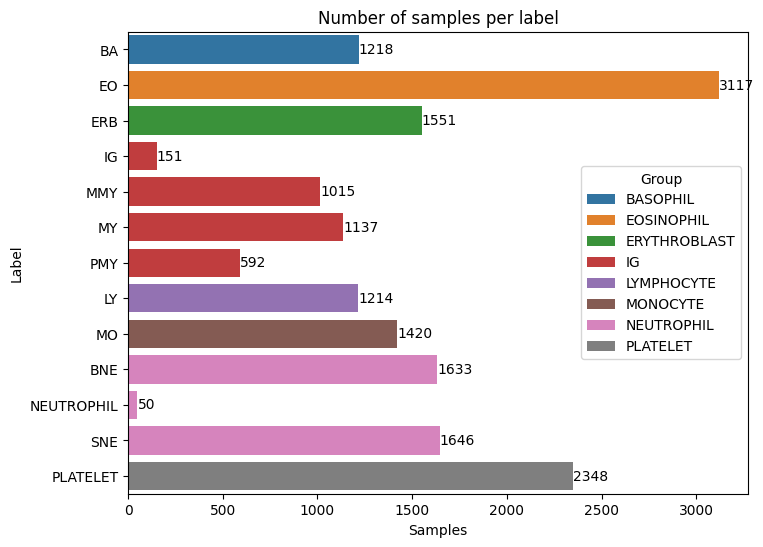

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=counts, x='size', y='label', hue='group', ax=ax, dodge=False)
ax.set_title('Number of samples per label')
ax.set_ylabel('Label')
ax.set_xlabel('Samples')
ax.legend(loc='center right', title='Group')
_ = [ax.bar_label(bars) for bars in ax.containers]

### Format des images

Nous dénombrons 7 tailles d'image différentes. La dimension la plus commune est 360x363 pixels qui représentent 97% des échantillons. Il faudra donc procéder à un traitement d'image sur les 453 autres images pour les mettre à la même dimension.

In [6]:
meta.value_counts(['width', 'height']).to_frame('count').reset_index()

width  height  count
0    360     363  16639
1    366     369    250
2    360     360    198
3    360     361      2
4    359     360      1
5    361     360      1
6    362     360      1

La fonction `central_pad_and_crop` s'occupe de cette opération de recadrage. Le traitement se fait en 2 passes :
1. Lorsqu'une dimension, largeur (*width*) ou hauteur (*height*), est **plus petite que la cible** (360x363) alors la fonction complète l'image (*padding*) en copiant l'information des bords (*edge*).
2. Lorsqu'une dimension, largeur (*width*) ou hauteur (*height*), est **plus grande que la cible** (360x363) alors la fonction recadre l'image (*cropping*) en supprimant l'information des bords (*edge*).

Nous avons donc exclu le redimensionnement qui pourrait engendrer des distorsions sur l'aspect des images (*ratio*). Nous avons choisi de d'ajouter ou de supprimer de l'information équitablement sur chaque bord de l'image pour maintenir l'information utile au centre de l'image.

Par exemple dans le cas d'une image de 362x360, nous avons 2 pixels de plus sur la largeur et 3 pixels de moins sur la hauteur pour atteindre notre cible de 360x363. L'opération consiste donc à supprimer 2 pixels sur les bords gauche (1px) et droite de l'image (1px) et à ajouter 3 pixels sur les bords haut (1px) et bas (2px).

In [7]:
# Attention la taille d'une image est exprimée sous la forme WxH
# Alors que la dimension d'un NumPy array est sour la forme [y, x]
# Le 3 correspond ici aux 3 canaux RGB (plus précisément BGR sous OpenCV)
filename = meta.loc[meta['image'] == 'ERB_8550.jpg', 'path'].squeeze()
img = cv2.imread(filename)
print(f"Original image: {img.shape}")
img2 = central_pad_and_crop(img, size=(360, 363))
print(f"Fitted image: {img2.shape}")

Original image: (360, 362, 3)
Fitted image: (363, 360, 3)


In [8]:
WIDTH, HEIGHT = 360, 363

images = pd.Series((cv2.imread(image) for image in meta['path']), index=meta.index)

idx = meta[meta[['width', 'height']].ne((WIDTH, HEIGHT)).any(axis=1)].index
images[idx] = images[idx].apply(central_pad_and_crop, size=(WIDTH, HEIGHT))

## 3.Visualisation des cellules

La fonction `show_image_with_hist` retourne une figure `Matplotlib` contenant 2 `Axes` avec l'image de la cellule au format BGR et son histogramme associé. Globalement, les histogrammes sont très similaires à l'exception des images qui n'ont pas été traitées avec la même méthodologie : il y a peut-être une piste à explorer pour normaliser les histogrammes.

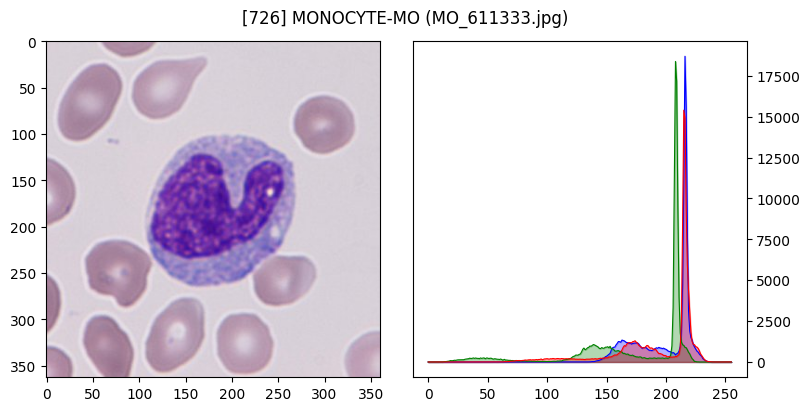

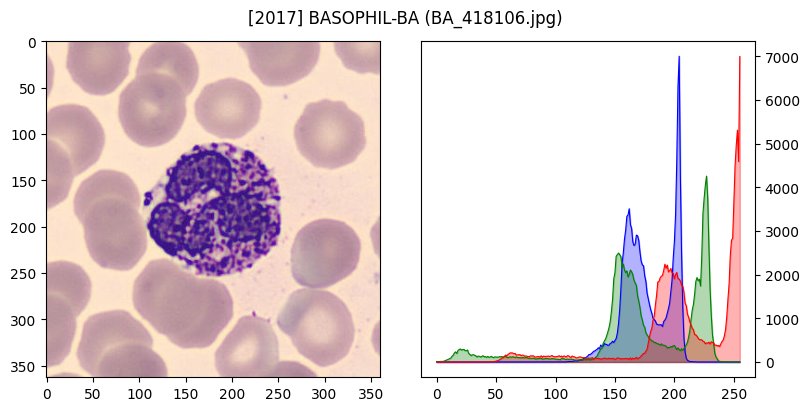

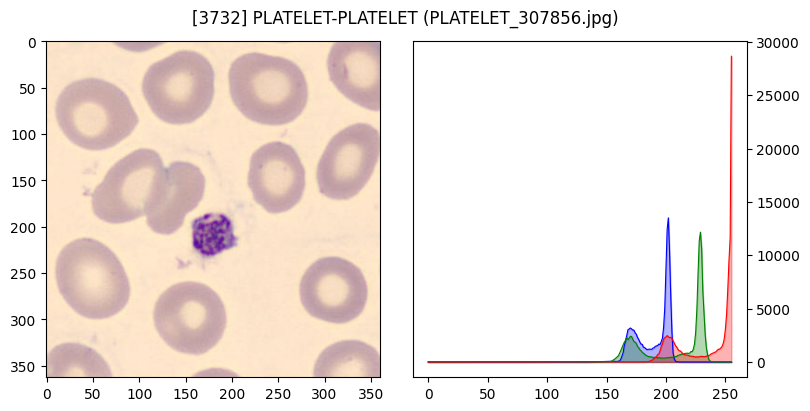

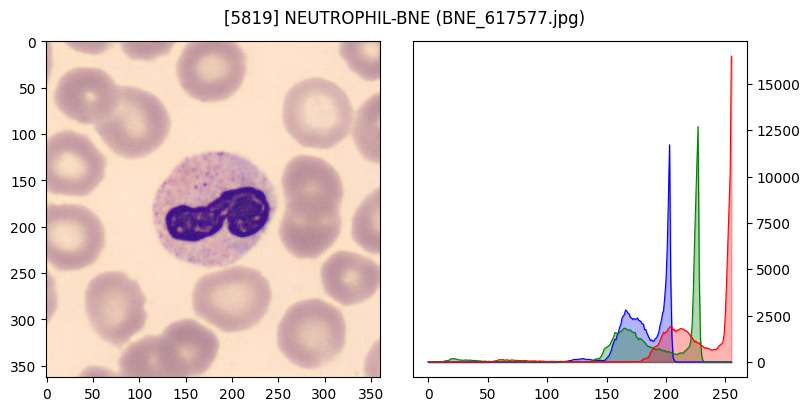

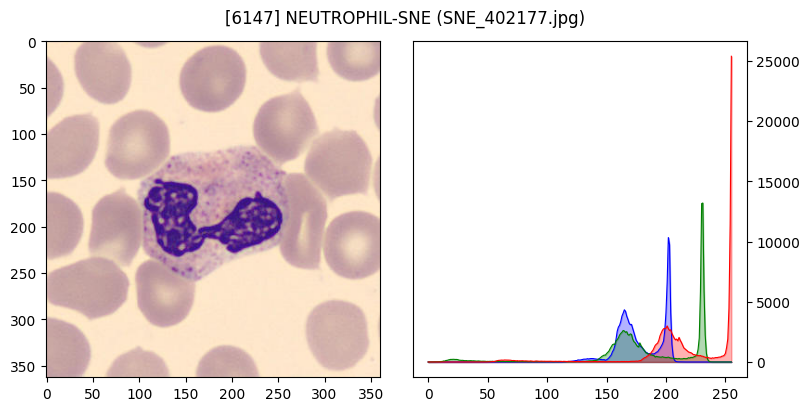

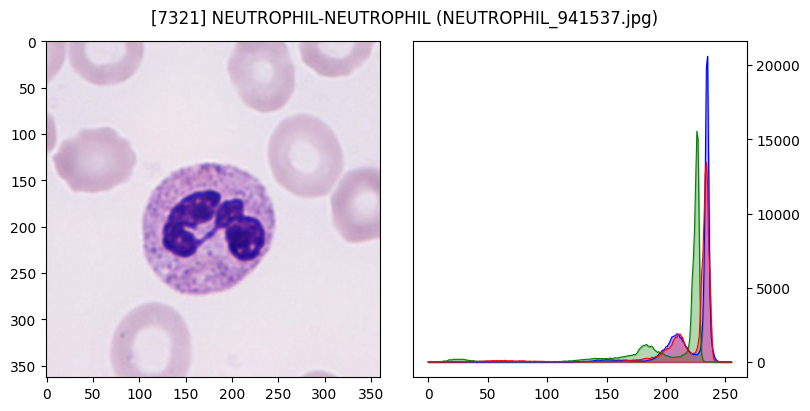

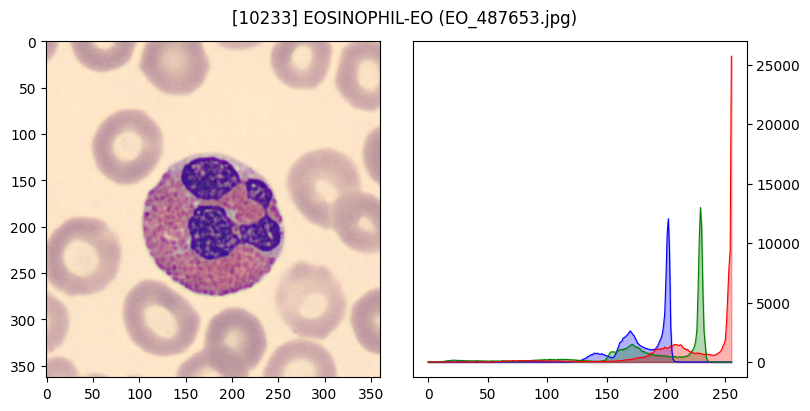

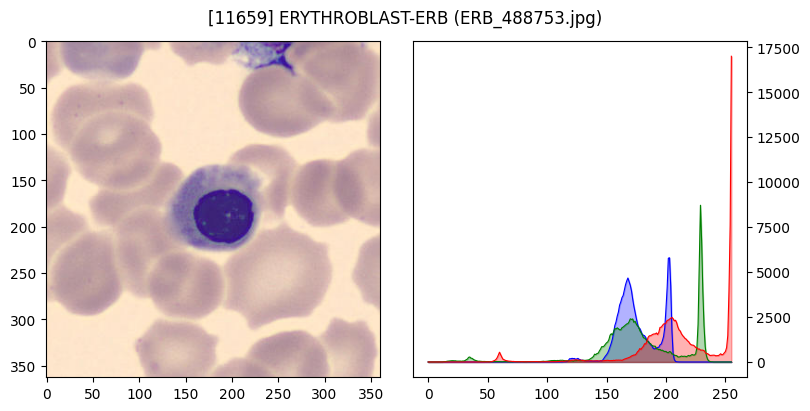

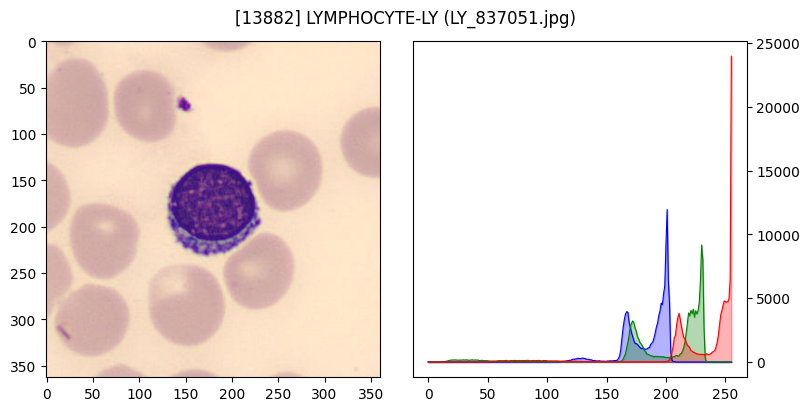

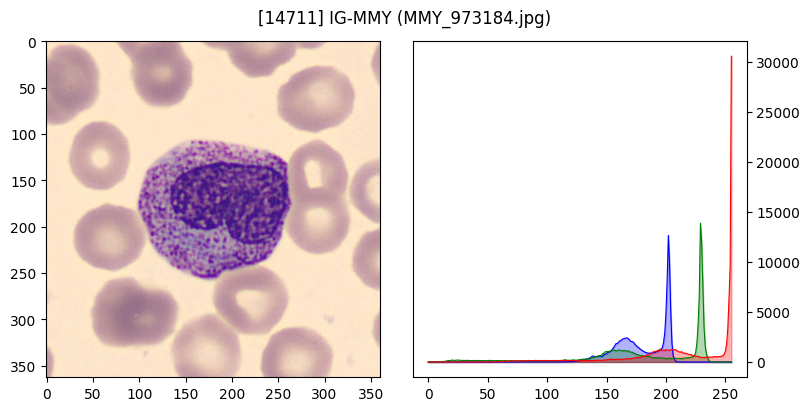

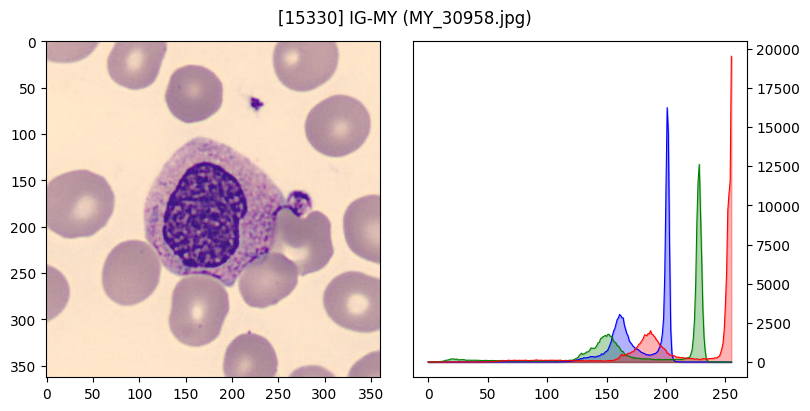

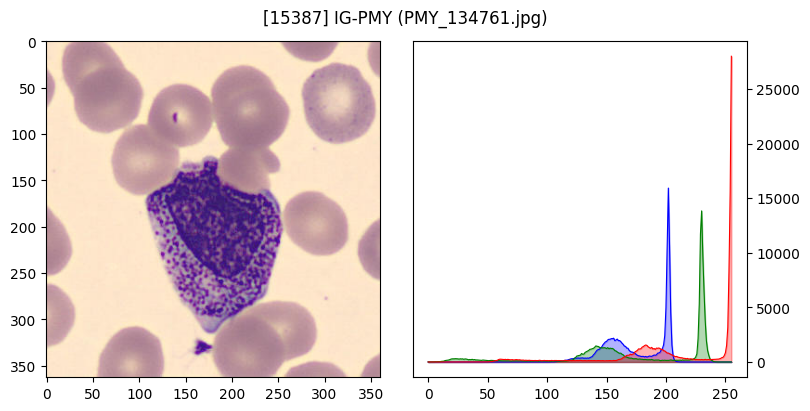

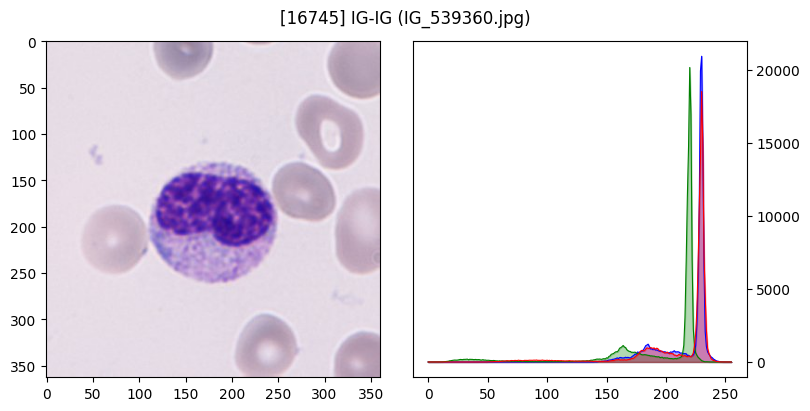

In [9]:
samples = meta.groupby(['group', 'label']).sample(n=1, random_state=2022).sort_index()

for rec in samples.itertuples():
    img = images[rec.Index]
    fig = show_image_with_hist(img)
    fig.suptitle(f"[{rec.Index}] {rec.group}-{rec.label} ({rec.image})")

### Balance des couleurs

Dans l'échantillon précédent, nous constatons un problème au niveau des couleurs des images. Bien que les images des cellules aient été prises avec le même équipement, le traitement photographique est différent selon certaines classes (vérifié lors de l'extraction des données EXIF des images).

Pour rééquilibrer les couleurs, nous appliquons une méthode décrite dans l'article [Comparison of traditional image processing and deep learning approaches for classification of white blood cells in peripheral blood smear images](https://www.sciencedirect.com/science/article/pii/S0208521618304819?ref=cra_js_challenge&fr=RR-1)

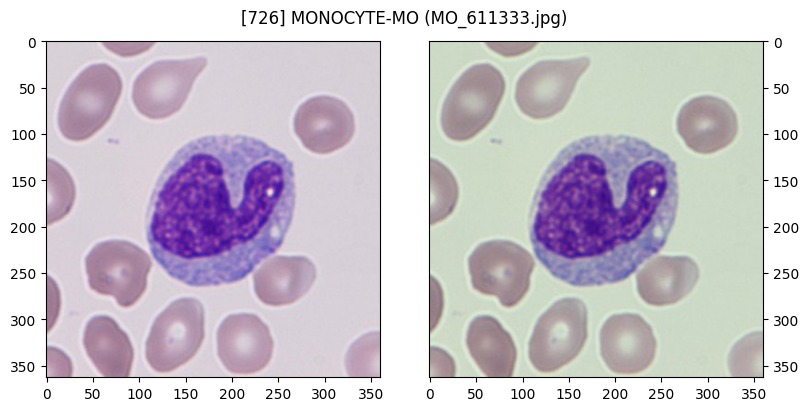

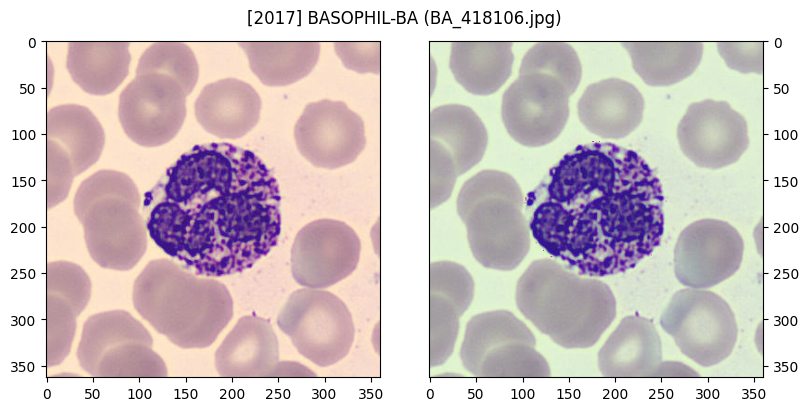

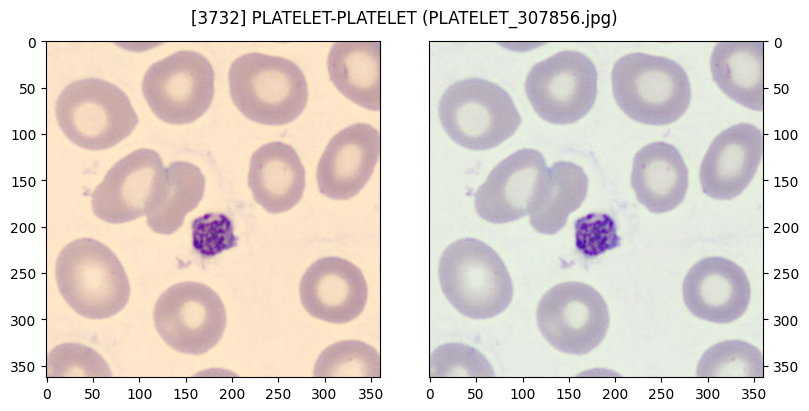

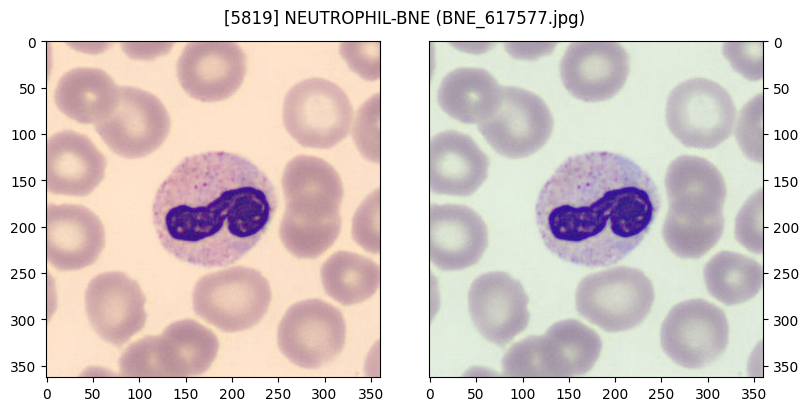

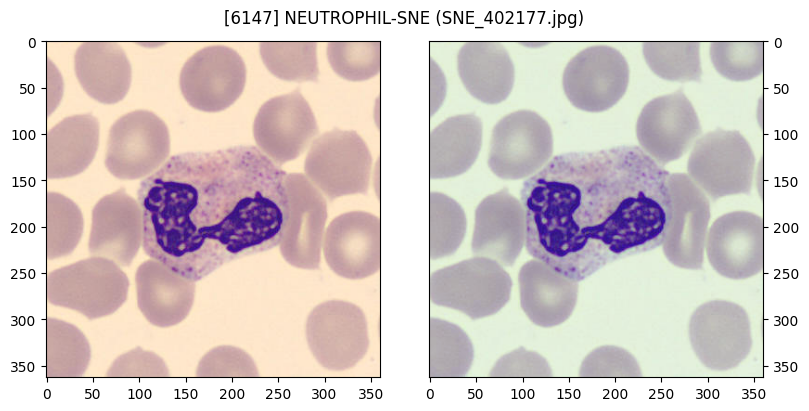

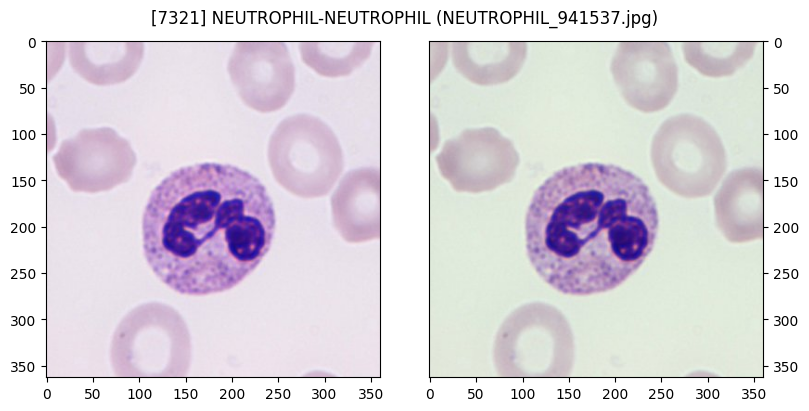

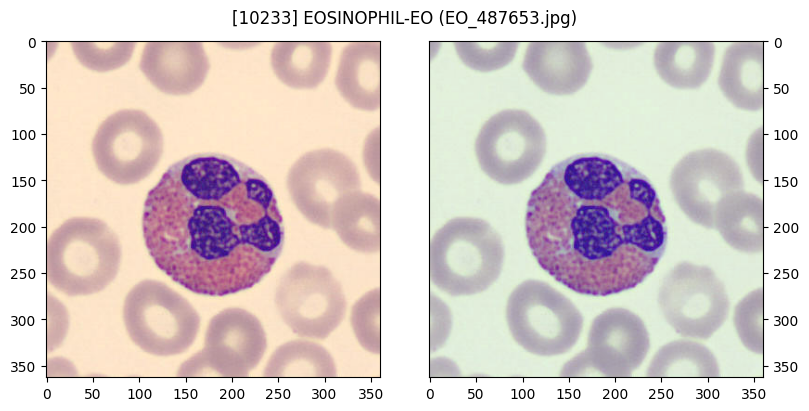

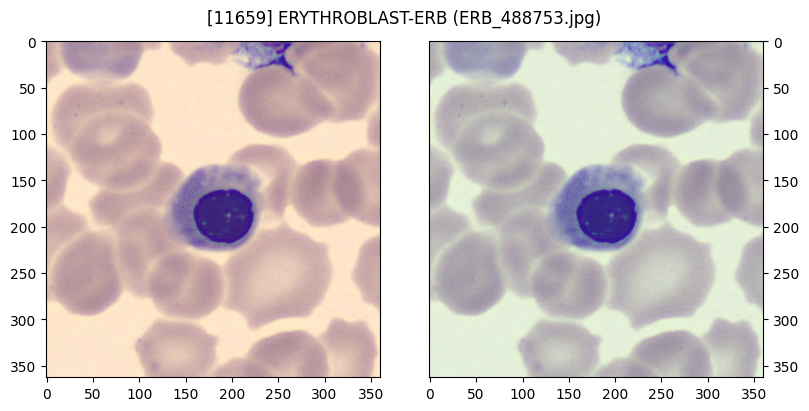

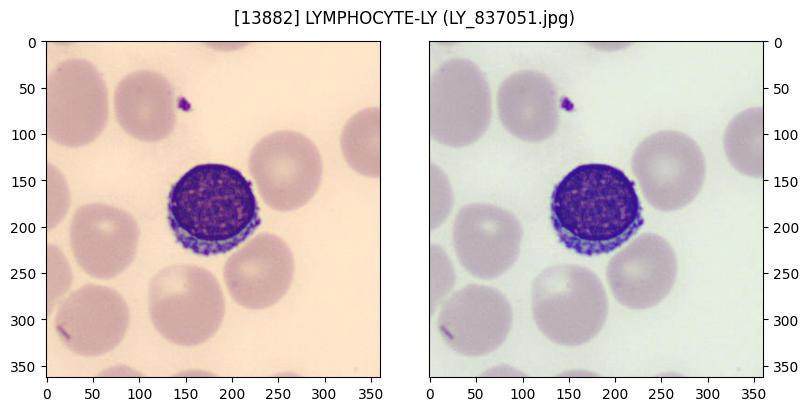

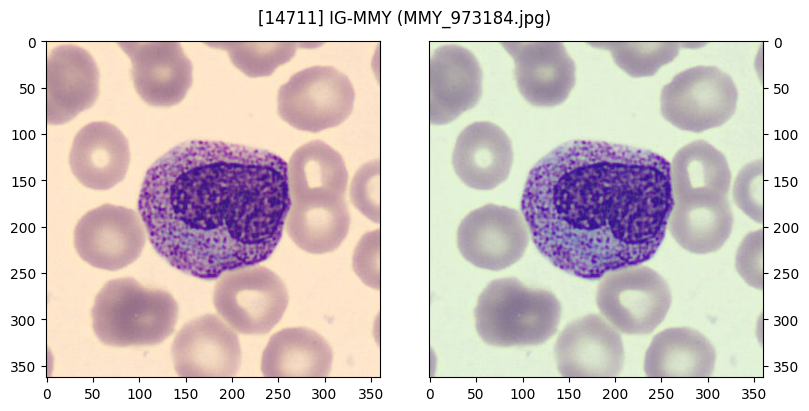

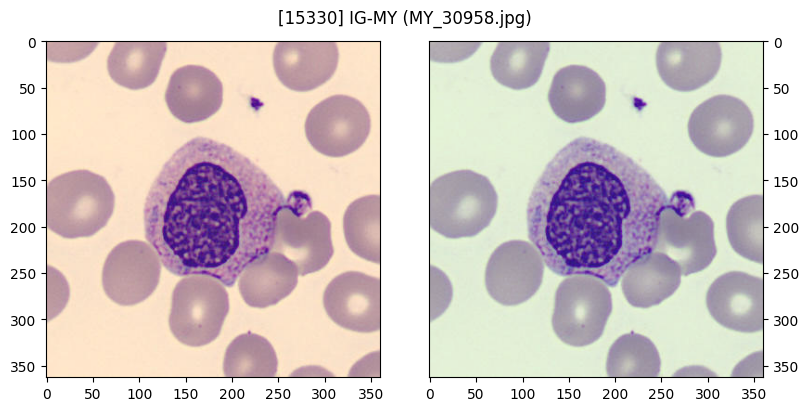

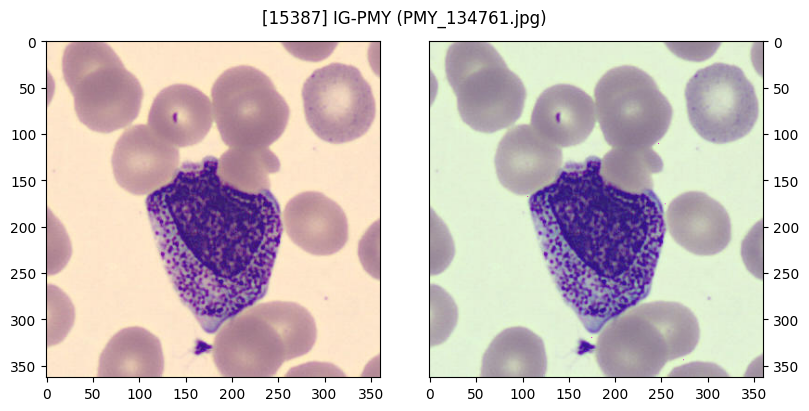

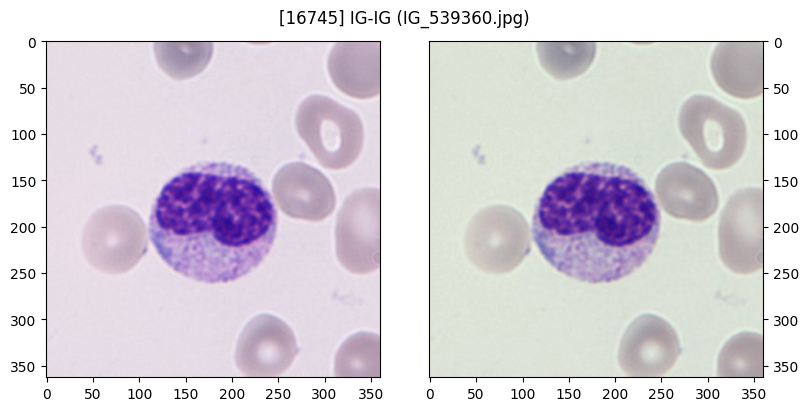

In [10]:
for rec in samples.itertuples():
    img = images[rec.Index]
    fig = show_image_with_hist(img)
    fig.suptitle(f"[{rec.Index}] {rec.group}-{rec.label} ({rec.image})")

    img2 = (img * cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).mean() / img.mean(axis=(0, 1))).astype(np.uint8)
    fig.axes[1].clear()
    fig.axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

### Conclusion

Ma compréhension :

1. Les 9-NEUTROPHIL-BNE (Band NEutrophil) devraient être affectés au groupe IG (Immature Granulocyte)
2. Les 3-IG-IG (0.88%) n'ont pas réussi à être classés comme MMY, MY ou PMY (MetaMYelocytes, MYelocytes, ProMYelocytes)
3. Les 10-NEUTROPHIL-NEUTROPHIL (0.29%) n'ont pas réussi à être classés comme BNE ou SNE (?)